In [1]:
%matplotlib inline

from fastai import *
from fastai.vision import *

from IPython.display import display
PATH = os.path.abspath('../..')

seed = 12345

In [2]:
# helper func for visualization
def evaluate_preds(Z_pred, Z_true, comment=''):
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111)
    *_, im = ax.hist2d(Z_true.flatten().numpy(), Z_pred.flatten().numpy(), bins=100, range=[[8.2, 9.3], [8.2, 9.3]], cmap='cubehelix_r', alpha=0.7)
    ax.plot([8.2, 9.3], [8.2, 9.3], c='k', ls='--', lw=3)
    ax.set_aspect(aspect='equal')

    ax.text(8.25, 9.15, f'{comment}\n' f'RMSE={root_mean_squared_error(Z_pred, Z_true):.4f}', fontsize=16)

    ax.set_xlabel('True', fontsize=12)
    ax.set_ylabel('Pred', fontsize=12)
    cb = fig.colorbar(im);
    cb.set_label('Number', fontsize=12)


# Get data

In [3]:
train_label_csv = f'{PATH}/catalogs/train.csv'
df = pd.read_csv(train_label_csv)

In [4]:
bs = 128
sz = 128

tfms = get_transforms(do_flip=True, flip_vert=True, max_rotate=15, max_zoom=1.15, p_lighting=0)

data = (ImageList.from_df(path=PATH, 
                          df=df, 
                          folder='train',
                          cols='objID',
                          suffix='.jpg')
        .split_by_rand_pct(0.2, seed=seed)
        .label_from_df(cols='oh_p50', label_cls=FloatList)
        .transform(tfms, size=sz)
        .databunch(bs=bs)
       )

In [5]:
# add test set
test_label_csv = f'{PATH}/catalogs/test.csv'

data.add_test(ImageList.from_df(path=PATH, 
                                df=pd.read_csv(test_label_csv),
                                folder='test',
                                cols='objID',
                                suffix='.jpg')
             )

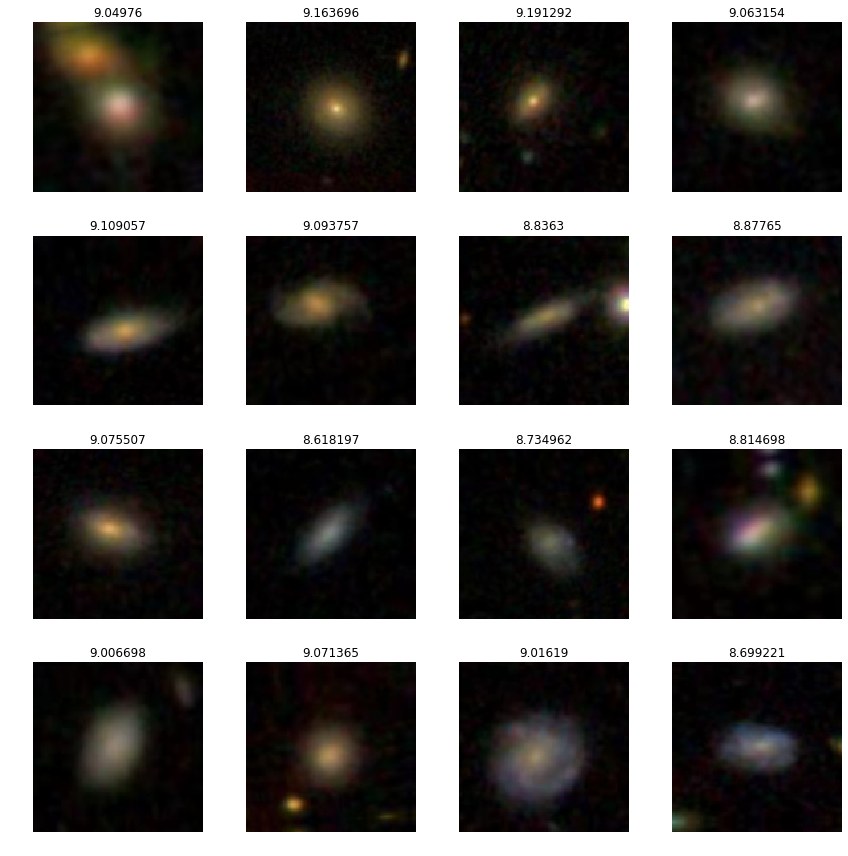

In [6]:
data.show_batch(4, figsize=(12, 12))

# Use resnet18, no dropout

Note to self: default is `ps=0.5`, and causes training loss to plateau at about 0.30. With dropout turned off `ps=0.`, we can achieve RMSE of 0.10 easily.

In [7]:
learn = cnn_learner(data, base_arch=models.resnet18, pretrained=True, ps=0., loss_func=root_mean_squared_error)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


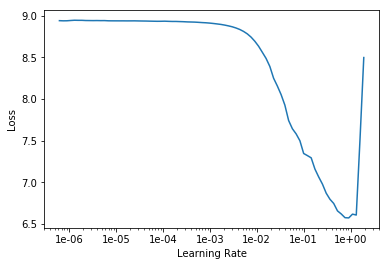

In [62]:
learn.lr_find()
learn.recorder.plot()

In [8]:
learn.fit(1, 1e-2)

epoch,train_loss,valid_loss,time
0,0.146235,0.154880,04:39


In [64]:
learn.unfreeze()
learn.fit(1, 1e-2)
learn.fit_one_cycle(8, slice(1e-4, 1e-3, 3e-3))

epoch,train_loss,valid_loss,time
0,0.137956,0.127005,00:48


epoch,train_loss,valid_loss,time
0,0.105951,0.099884,00:48
1,0.106581,0.097138,00:49
2,0.102206,0.097212,00:49
3,0.101875,0.098905,00:49
4,0.100199,0.093932,00:48
5,0.099723,0.094479,00:49
6,0.100810,0.093828,00:50
7,0.097176,0.094688,00:48


## Test and evaluate

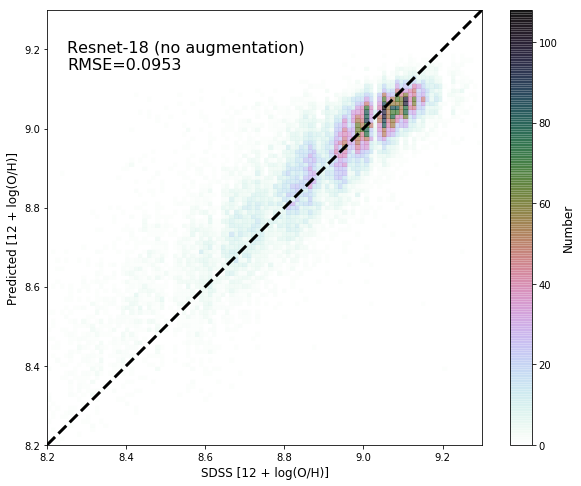

In [68]:
Z_pred, Z_true = learn.get_preds()
evaluate_preds(Z_pred, Z_true, comment='Resnet-18 (no augmentation)')

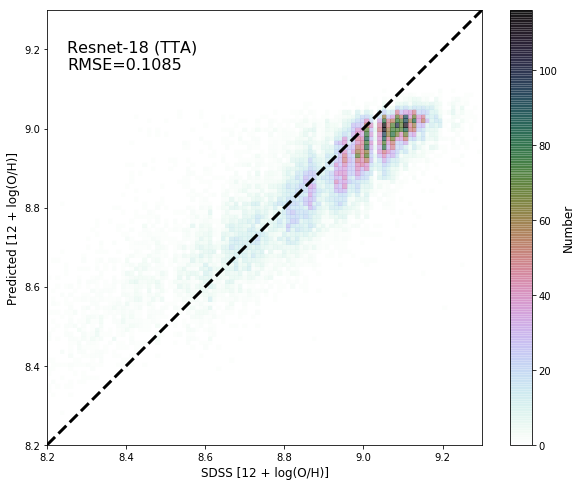

In [67]:
Z_pred, Z_true = learn.TTA()
evaluate_preds(Z_pred, Z_true, comment='Resnet-18 (TTA)')

# Resnet-34, no dropout, high lr

In [73]:
learn = cnn_learner(data, base_arch=models.resnet34, pretrained=True, ps=0., loss_func=root_mean_squared_error)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


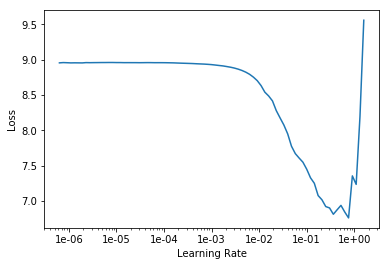

In [70]:
learn.lr_find()
learn.recorder.plot()

In [74]:
learn.fit(1, 1e-1)
learn.unfreeze()
learn.fit(1, 1e-1)
learn.fit_one_cycle(8, slice(1e-3, 3e-3, 1e-2))

epoch,train_loss,valid_loss,time
0,0.300375,3.049748,00:52


epoch,train_loss,valid_loss,time
0,0.354922,0.237707,01:11


epoch,train_loss,valid_loss,time
0,0.110580,0.328897,01:11
1,0.111545,0.109755,01:11
2,0.110943,0.105492,01:11
3,0.106771,0.108979,01:11
4,0.107827,0.101995,01:11
5,0.105203,0.100269,01:11
6,0.106746,0.100425,01:11
7,0.105112,0.099743,01:11


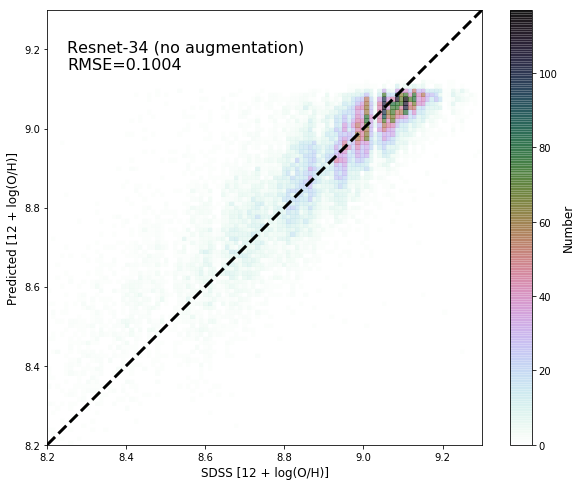

In [75]:
Z_pred, Z_true = learn.get_preds()
evaluate_preds(Z_pred, Z_true, comment='Resnet-34 (no augmentation)')

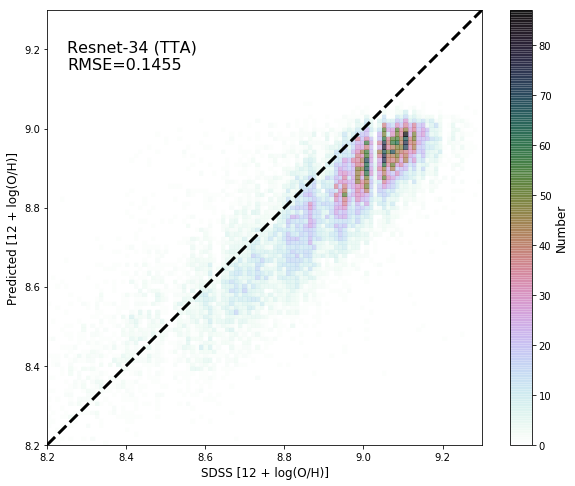

In [76]:
Z_pred, Z_true = learn.TTA()
evaluate_preds(Z_pred, Z_true, comment='Resnet-34 (TTA)')

# Resnet-34, no dropout, lower learning rates 

In [77]:
learn = cnn_learner(data, base_arch=models.resnet34, pretrained=True, ps=0., loss_func=root_mean_squared_error)

In [78]:
learn.fit(1, 3e-2)
learn.unfreeze()
learn.fit(1, 1e-2)
learn.fit_one_cycle(8, slice(1e-4, 3e-4, 1e-3))

epoch,train_loss,valid_loss,time
0,0.166615,0.189789,00:52


epoch,train_loss,valid_loss,time
0,0.123760,0.131418,01:11


epoch,train_loss,valid_loss,time
0,0.104150,0.106051,01:11
1,0.100071,0.149522,01:11
2,0.102723,0.140549,01:11
3,0.100377,0.118714,01:11
4,0.100865,0.120558,01:11
5,0.099857,0.096075,01:11
6,0.101100,0.100053,01:11
7,0.100366,0.103482,01:11


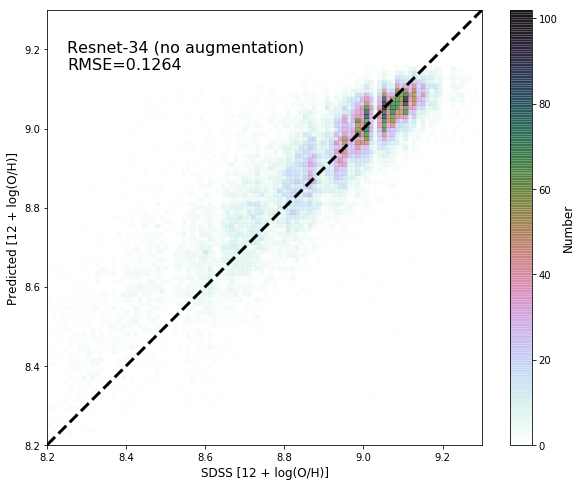

In [79]:
Z_pred, Z_true = learn.get_preds()
evaluate_preds(Z_pred, Z_true, comment='Resnet-34 (no augmentation)')

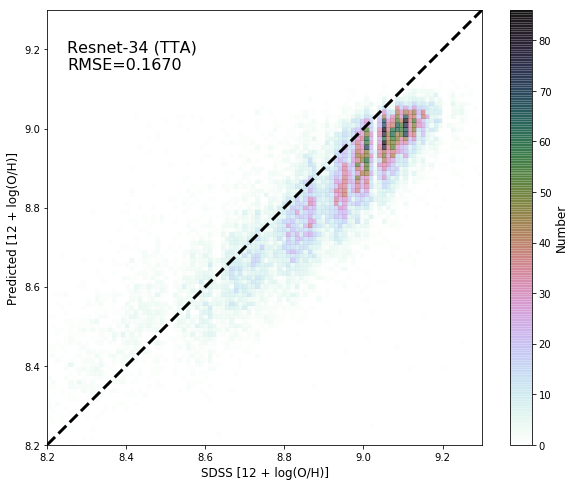

In [80]:
Z_pred, Z_true = learn.TTA()
evaluate_preds(Z_pred, Z_true, comment='Resnet-34 (TTA)')

# Resnet-34, small dropout (`p=0.05, 0.1`) and high lr

In [9]:
learn = cnn_learner(data, base_arch=models.resnet34, pretrained=True, ps=[0.05, 0.1], loss_func=root_mean_squared_error)

In [10]:
learn.model[-1]

Sequential(
  (0): AdaptiveConcatPool2d(
    (ap): AdaptiveAvgPool2d(output_size=1)
    (mp): AdaptiveMaxPool2d(output_size=1)
  )
  (1): Flatten()
  (2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Dropout(p=0.25)
  (4): Linear(in_features=1024, out_features=512, bias=True)
  (5): ReLU(inplace)
  (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): Dropout(p=0.5)
  (8): Linear(in_features=512, out_features=1, bias=True)
)

In [ ]:
learn.fit(1, 3e-2)
learn.unfreeze()
learn.fit_one_cycle(1, 1e-2, pct_start=0)
learn.fit_one_cycle(8, slice(1e-3, 3e-3, 1e-2))

epoch,train_loss,valid_loss,time
0,0.266198,0.185722,00:52


epoch,train_loss,valid_loss,time
0,0.188701,1.016036,01:11


epoch,train_loss,valid_loss,time
0,0.185259,26.979813,01:11
1,0.174359,7.160009,01:11
2,0.166202,1.778973,01:11
3,0.165431,0.242904,01:11


In [94]:
root_mean_squared_error(Z_pred, Z_true)

tensor(0.3173)

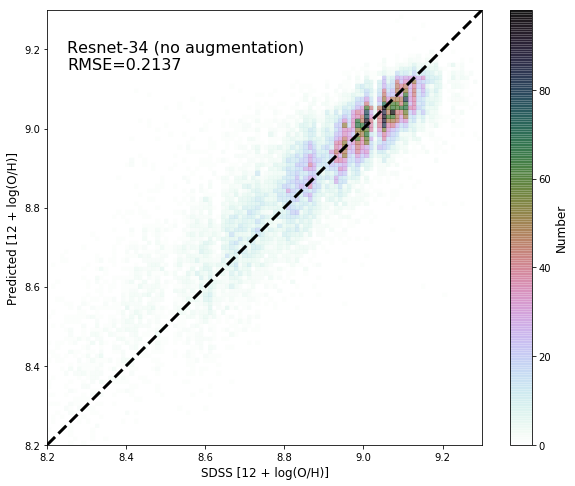

In [92]:
Z_pred, Z_true = learn.get_preds()
evaluate_preds(Z_pred, Z_true, comment='Resnet-34 (no augmentation)')

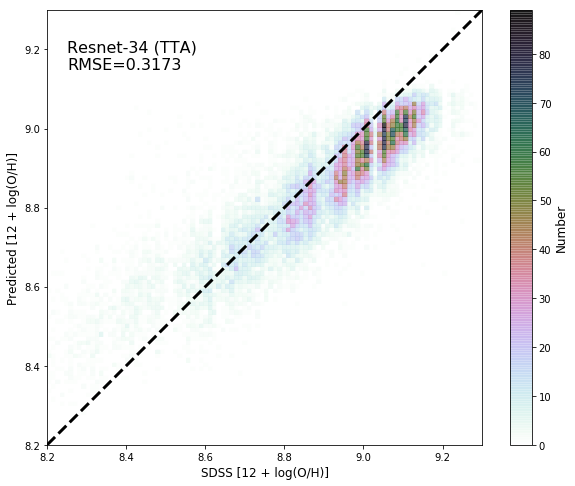

In [93]:
Z_pred, Z_true = learn.TTA()
evaluate_preds(Z_pred, Z_true, comment='Resnet-34 (TTA)')

# Resnet-34, high dropout (`ps=[0.25, 0.5]`), high lr

In [11]:
learn = cnn_learner(data, base_arch=models.resnet34, pretrained=True, ps=[0.25, 0.5], loss_func=root_mean_squared_error)

In [12]:
learn.fit(1, 3e-2)
learn.unfreeze()
learn.fit_one_cycle(1, 1e-2, pct_start=0)
learn.fit_one_cycle(8, slice(1e-3, 3e-3, 1e-2))

epoch,train_loss,valid_loss,time
0,0.414802,1.402251,00:59


epoch,train_loss,valid_loss,time
0,0.317699,0.132058,01:13


epoch,train_loss,valid_loss,time
0,0.311565,0.169570,01:13
1,0.307580,0.626241,01:13
2,0.287572,0.142846,01:13
3,0.278872,0.112174,01:13
4,0.263500,0.101299,01:13
5,0.262069,0.095785,01:13
6,0.249731,0.095755,01:13
7,0.247889,0.093998,01:13


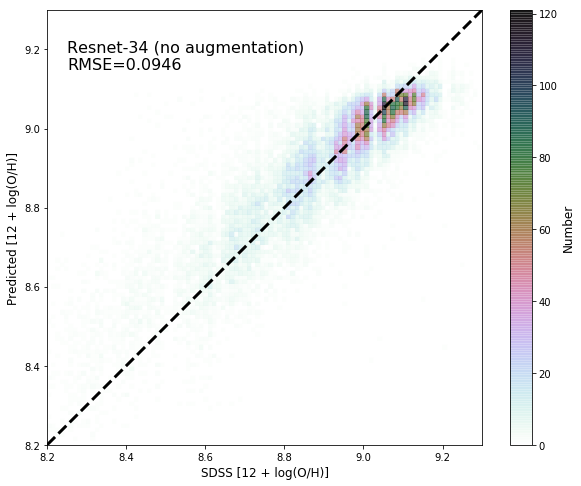

In [13]:
Z_pred, Z_true = learn.get_preds()
evaluate_preds(Z_pred, Z_true, comment='Resnet-34 (no augmentation)')

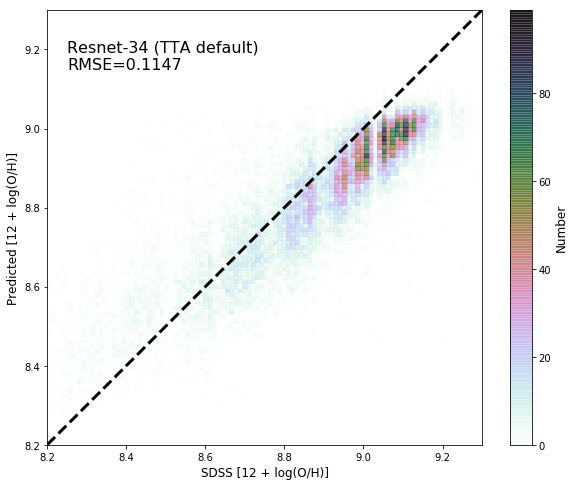

In [14]:
Z_pred, Z_true = learn.TTA()
evaluate_preds(Z_pred, Z_true, comment='Resnet-34 (TTA default)')

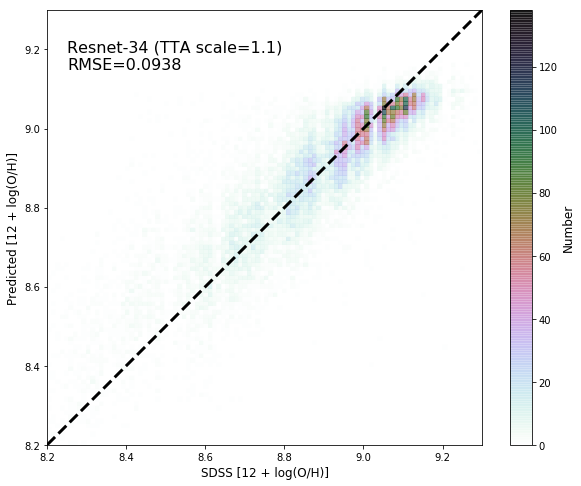

In [16]:
Z_pred, Z_true = learn.TTA(scale=1.1)
evaluate_preds(Z_pred, Z_true, comment='Resnet-34 (TTA scale=1.1)')

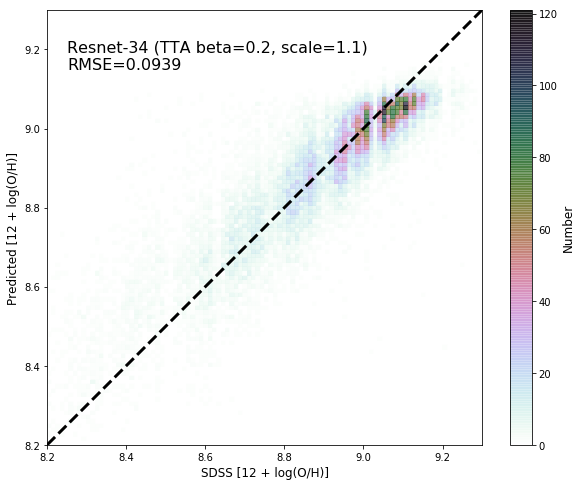

In [17]:
Z_pred, Z_true = learn.TTA(beta=0.2, scale=1.1)
evaluate_preds(Z_pred, Z_true, comment='Resnet-34 (TTA beta=0.2, scale=1.1)')

# Resnet-18, high-dropout, high lr, longer training

In [19]:
learn = cnn_learner(data, base_arch=models.resnet18, pretrained=True, ps=[0.25, 0.5], loss_func=root_mean_squared_error)

In [20]:
learn.fit(1, 3e-2)
learn.unfreeze()
learn.fit_one_cycle(1, 1e-2, pct_start=0)
learn.fit_one_cycle(15, slice(1e-3, 3e-3, 1e-2))

epoch,train_loss,valid_loss,time
0,0.453407,0.200472,00:57


epoch,train_loss,valid_loss,time
0,0.321463,0.112986,00:57


epoch,train_loss,valid_loss,time
0,0.314498,0.115145,00:58
1,0.306738,0.128827,00:57
2,0.304436,0.120738,00:57
3,0.295985,0.137053,00:58
4,0.278126,0.108415,00:57
5,0.269859,0.098944,00:57
6,0.257124,0.212083,00:57
7,0.244871,0.102969,00:58
8,0.237933,0.137947,00:57
9,0.226133,0.094831,00:58


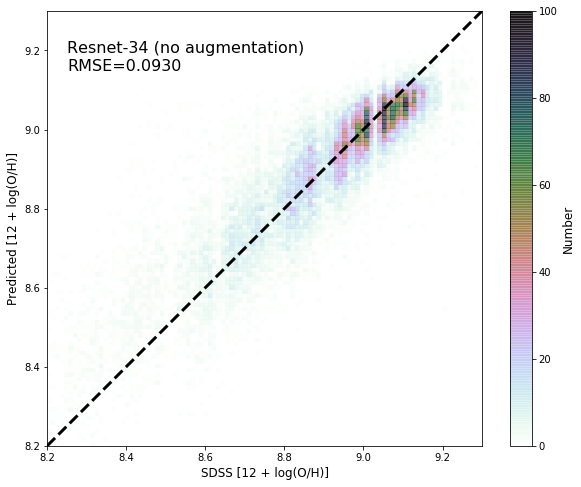

In [21]:
Z_pred, Z_true = learn.get_preds()
evaluate_preds(Z_pred, Z_true, comment='Resnet-18 (no augmentation)')

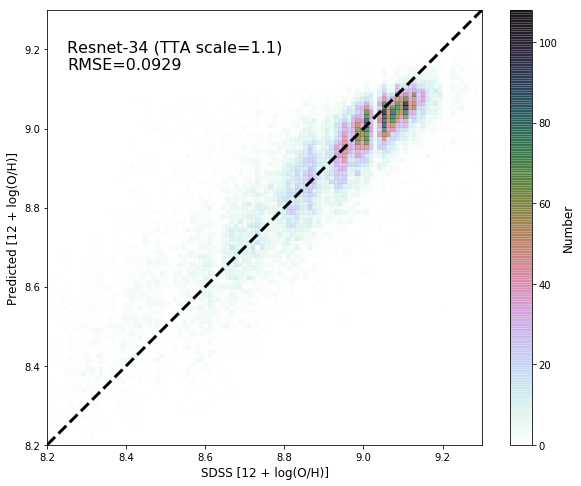

In [22]:
Z_pred, Z_true = learn.TTA(scale=1.1)
evaluate_preds(Z_pred, Z_true, comment='Resnet-18 (TTA scale=1.1)')

# Resnet-18, *from scratch*, high-dropout, high-lr, longer training

In [23]:
learn = cnn_learner(data, base_arch=models.resnet18, pretrained=False, ps=[0.25, 0.5], loss_func=root_mean_squared_error)

In [24]:
learn.fit(1, 3e-2)
learn.unfreeze()
learn.fit_one_cycle(1, 1e-2, pct_start=0)
learn.fit_one_cycle(15, slice(1e-3, 3e-3, 1e-2))

epoch,train_loss,valid_loss,time
0,0.428168,0.229341,00:57


epoch,train_loss,valid_loss,time
0,0.315214,0.109300,00:57


epoch,train_loss,valid_loss,time
0,0.306385,0.107027,00:57
1,0.307415,0.121415,00:57
2,0.298449,0.106058,00:57
3,0.291348,0.105317,00:57
4,0.275816,0.098733,00:57
5,0.264364,0.114242,00:58
6,0.253741,0.106965,00:58
7,0.243622,0.119711,00:57
8,0.233370,0.094714,00:57
9,0.227453,0.093631,00:57


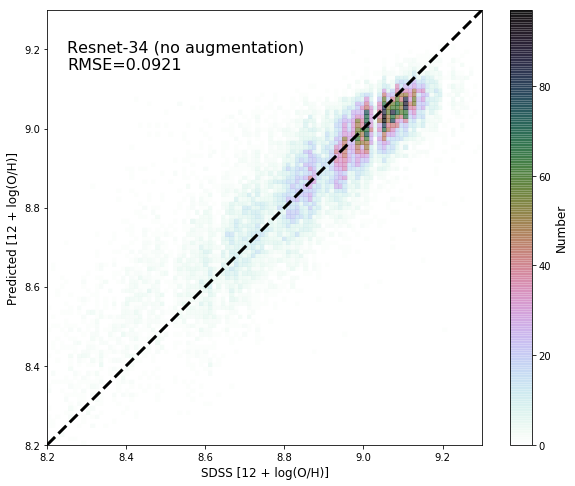

In [25]:
Z_pred, Z_true = learn.get_preds()
evaluate_preds(Z_pred, Z_true, comment='Resnet-18 (no augmentation)')

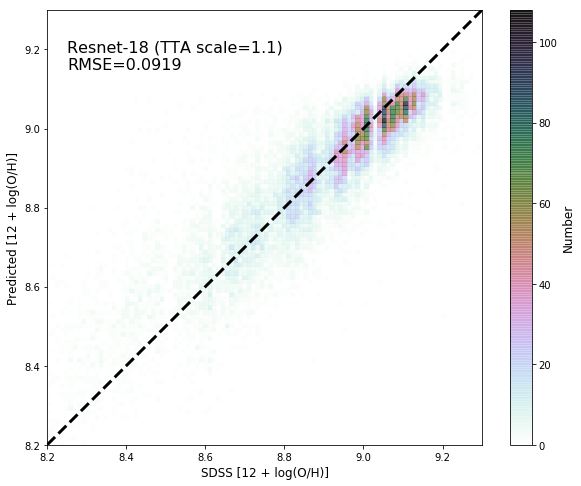

In [26]:
Z_pred, Z_true = learn.TTA(scale=1.1)
evaluate_preds(Z_pred, Z_true, comment='Resnet-18 (TTA scale=1.1)')

# Resnet-18 *from scratch*, high-dropout, high-lr, `bs=512`, longer training

In [27]:
bs = 512

data = (ImageList.from_df(path=PATH, 
                          df=df, 
                          folder='train',
                          cols='objID',
                          suffix='.jpg')
        .split_by_rand_pct(0.2, seed=seed)
        .label_from_df(cols='oh_p50', label_cls=FloatList)
        .transform(tfms, size=sz)
        .databunch(bs=bs)
       )

In [28]:
learn = cnn_learner(data, base_arch=models.resnet18, pretrained=False, ps=[0.25, 0.5], loss_func=root_mean_squared_error)

In [29]:
learn.fit(1, 3e-2)
learn.unfreeze()
learn.fit_one_cycle(1, 1e-2, pct_start=0)
learn.fit_one_cycle(15, slice(1e-3, 3e-3, 1e-2))

epoch,train_loss,valid_loss,time
0,0.704373,0.242994,01:03


epoch,train_loss,valid_loss,time
0,0.411630,0.118760,00:59


epoch,train_loss,valid_loss,time
0,0.397166,0.115266,00:58
1,0.391852,0.116610,00:59
2,0.384190,0.113482,00:59
3,0.374288,0.110101,00:59
4,0.364531,0.121271,00:58
5,0.355238,0.109804,00:59
6,0.348910,0.104402,00:58
7,0.343522,0.117635,00:58
8,0.338804,0.106467,00:58
9,0.334432,0.101695,00:58


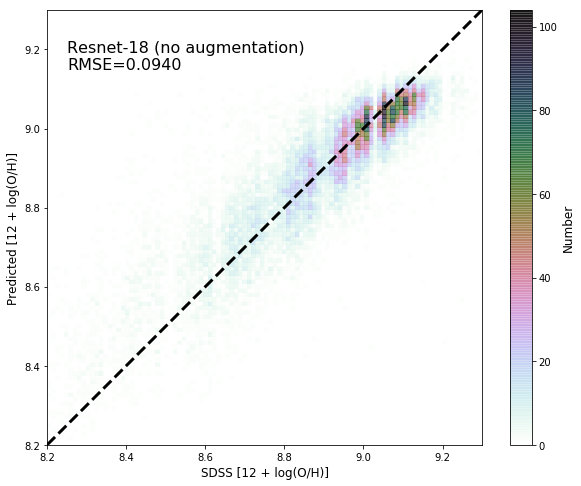

In [30]:
Z_pred, Z_true = learn.get_preds()
evaluate_preds(Z_pred, Z_true, comment='Resnet-18 (no augmentation)')

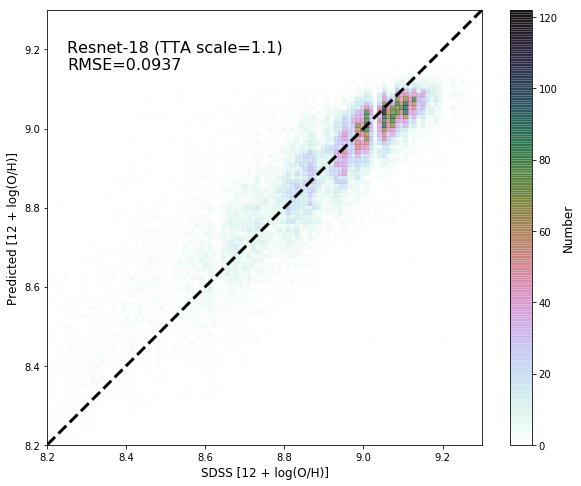

In [31]:
Z_pred, Z_true = learn.TTA(scale=1.1)
evaluate_preds(Z_pred, Z_true, comment='Resnet-18 (TTA scale=1.1)')

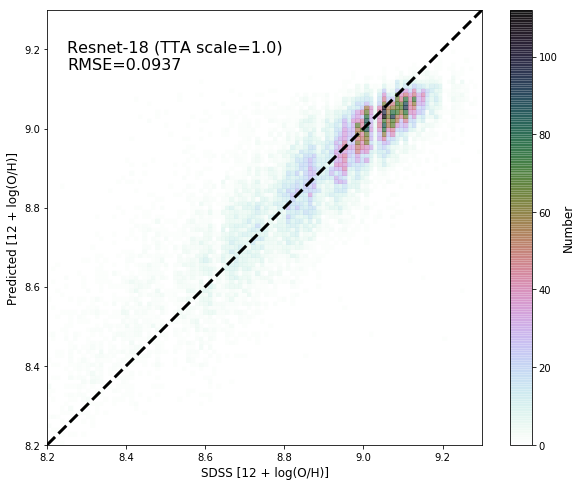

In [32]:
Z_pred, Z_true = learn.TTA(scale=1.0)
evaluate_preds(Z_pred, Z_true, comment='Resnet-18 (TTA scale=1.0)')

# Resnet-34 *from scratch*, high-dropout, high-lr, single-shot long training

In [27]:
bs = 128

data = (ImageList.from_df(path=PATH, 
                          df=df, 
                          folder='train',
                          cols='objID',
                          suffix='.jpg')
        .split_by_rand_pct(0.2, seed=seed)
        .label_from_df(cols='oh_p50', label_cls=FloatList)
        .transform(tfms, size=sz)
        .databunch(bs=bs)
       )

In [28]:
learn = cnn_learner(data, base_arch=models.resnet34, pretrained=False, ps=[0.25, 0.5], loss_func=root_mean_squared_error)

In [29]:
learn.unfreeze()
learn.fit_one_cycle(40, slice(1e-3, 1e-2))

epoch,train_loss,valid_loss,time
0,1.182685,0.267823,01:15
1,0.716508,0.164619,01:15
2,0.523931,0.129423,01:15
3,0.434857,0.298268,01:15
4,0.396237,0.196045,01:16
5,0.356960,0.127397,01:16
6,0.346291,0.227000,01:16
7,0.327023,0.409616,01:16
8,0.299673,0.199052,01:16
9,0.284098,0.104292,01:16


Final `valid_loss = 0.086746`

In [30]:
learn.save('resnet34-from_scratch-bs_128-single_shot_40epochs_training')

(0.05, 0.5)

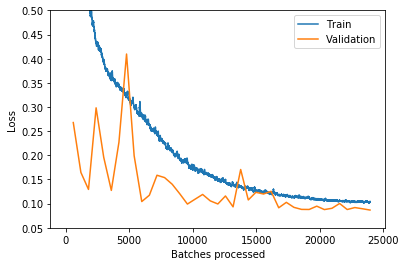

In [40]:
learn.recorder.plot_losses()
plt.ylim(0.05, 0.5)

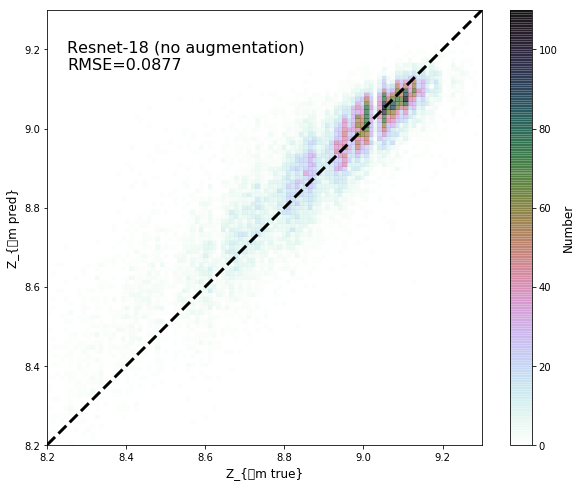

In [33]:
Z_pred, Z_true = learn.get_preds()
evaluate_preds(Z_pred, Z_true, comment='Resnet-34 (no augmentation)')

## Some variations on TTA `scale`

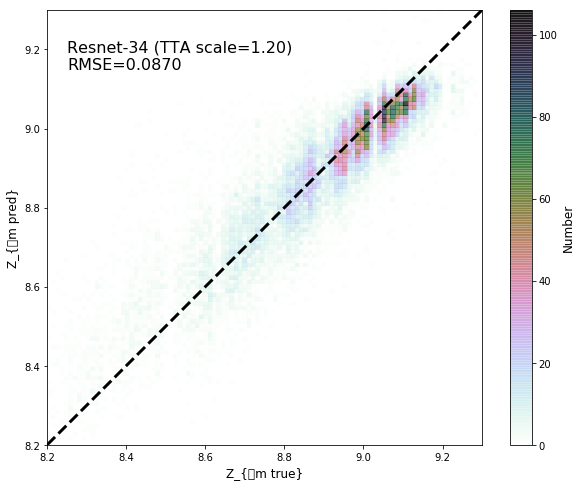

In [38]:
Z_pred, Z_true = learn.TTA(scale=1.20)
evaluate_preds(Z_pred, Z_true, comment='Resnet-34 (TTA scale=1.20)')

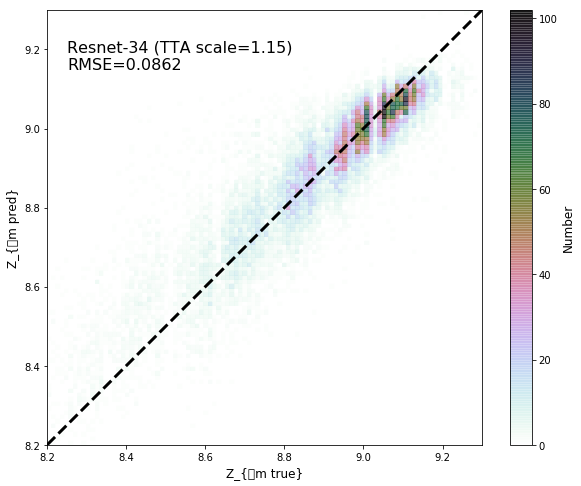

In [37]:
Z_pred, Z_true = learn.TTA(scale=1.15)
evaluate_preds(Z_pred, Z_true, comment='Resnet-34 (TTA scale=1.15)')

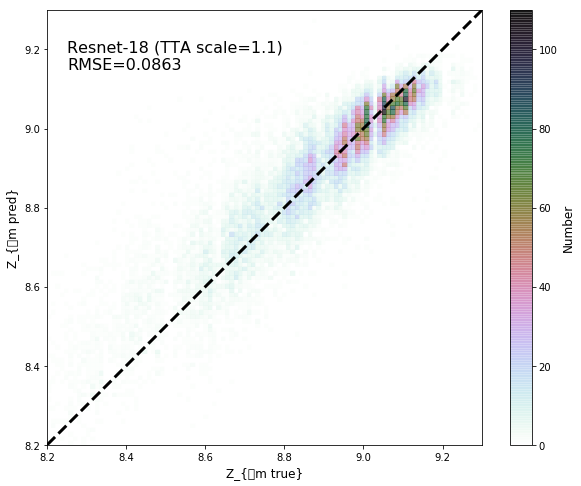

In [34]:
Z_pred, Z_true = learn.TTA(scale=1.1)
evaluate_preds(Z_pred, Z_true, comment='Resnet-34 (TTA scale=1.1)')

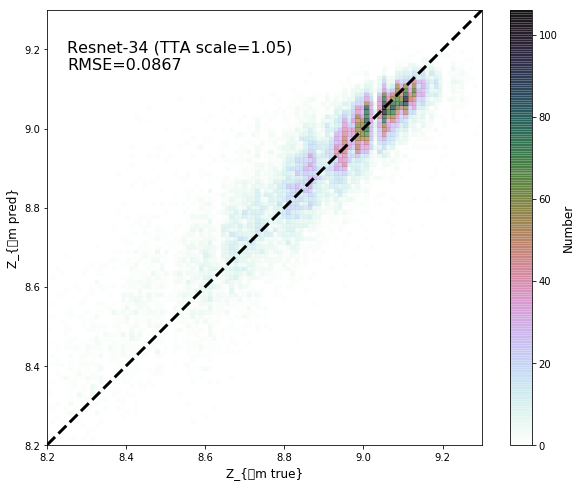

In [35]:
Z_pred, Z_true = learn.TTA(scale=1.05)
evaluate_preds(Z_pred, Z_true, comment='Resnet-34 (TTA scale=1.05)')

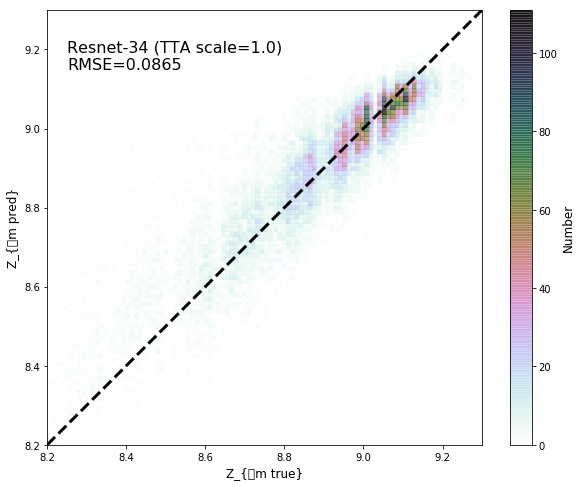

In [36]:
Z_pred, Z_true = learn.TTA(scale=1.0)
evaluate_preds(Z_pred, Z_true, comment='Resnet-34 (TTA scale=1.0)')

# Repeat but with smaller batches

In [6]:
bs = 64

data = (ImageList.from_df(path=PATH, 
                          df=df, 
                          folder='train',
                          cols='objID',
                          suffix='.jpg')
        .split_by_rand_pct(0.2, seed=seed)
        .label_from_df(cols='oh_p50', label_cls=FloatList)
        .transform(tfms, size=sz)
        .databunch(bs=bs, num_workers=8)
       )

learn = cnn_learner(data, base_arch=models.resnet34, pretrained=False, ps=[0.25, 0.5], loss_func=root_mean_squared_error)
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


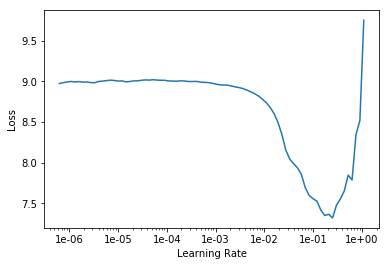

In [28]:
learn.lr_find()
learn.recorder.plot()

In [7]:
learn.fit_one_cycle(40, slice(1e-3, 1e-2))

epoch,train_loss,valid_loss,time
0,0.880483,0.439899,01:30
1,0.575691,0.167344,01:43
2,0.443631,0.210009,01:55
3,0.379472,0.201170,02:39
4,0.370130,0.242382,02:57
5,0.324821,0.117330,02:59
6,0.304845,0.148683,03:01
7,0.296508,0.137785,01:56
8,0.259091,0.118497,01:25
9,0.226998,0.210275,01:44


In [8]:
learn.save('resnet34-from_scratch-bs_64-single_shot_40epochs_training')

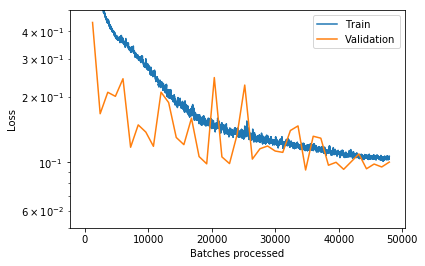

In [11]:
learn.recorder.plot_losses()
plt.ylim(0.05, 0.5)
plt.yscale('log');

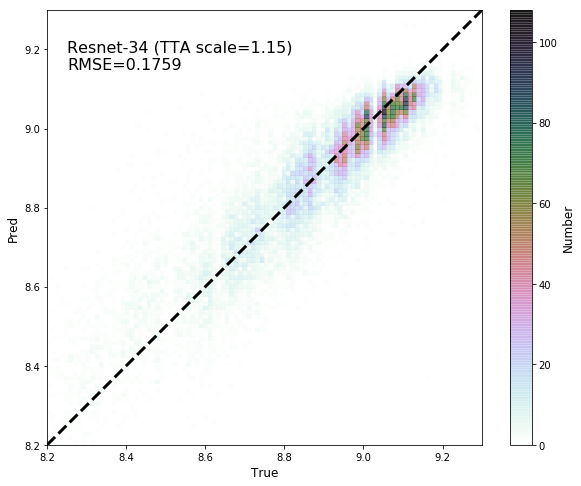

In [10]:
Z_pred, Z_true = learn.TTA(scale=1.15)
evaluate_preds(Z_pred, Z_true, comment='Resnet-34 (TTA scale=1.15)')